# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


In [2]:
# %pdb

## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

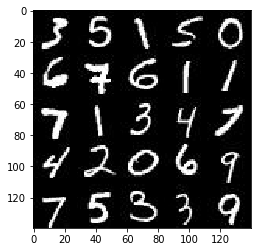

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

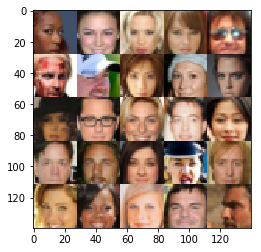

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_img')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='z_dim')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_img, input_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha=0.2
        x = tf.layers.conv2d(images, 64, 5, 2, padding='same')
        x = tf.maximum(alpha*x, x)
        # shape is 14x14x64
        conv2 = tf.layers.conv2d(x, 128, 5, 2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        lr2 = tf.maximum(alpha*bn2, bn2)
        # now the shape is 7x7x128
        conv3 = tf.layers.conv2d(lr2, 256, 5, 2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        lr3 = tf.maximum(bn3*alpha, bn3)
        # now the shape is 4x4x256
        
        flat = tf.reshape(lr3, (-1, 4*4*256))
        
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)
        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    # if all the padding is same, for 28 is about 14, 7
    with tf.variable_scope('generator', reuse=not is_train):
        #100 ==> 4x4x1024
        alpha = 0.2
        x = tf.layers.dense(z, 4*4*512)
#         print(z.get_shape)
        x = tf.reshape(x, (-1, 4, 4, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)

        # cov2  ==>7x7x512
        wdjjd = tf.image.resize_nearest_neighbor(x, (7,7))
        conv2 = tf.layers.conv2d(wdjjd, 256, 5, 1, padding='same')
#         conv2 = tf.layers.conv2d_transpose(x, 512, 5, 2, padding='valid')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(conv2*alpha, conv2)

        
        #### 14x14x256
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, 2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3, training=is_train)
        lrelu3 = tf.maximum(bn3*alpha, bn3)
        # conv3 ==> 28x28x128
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, 2, padding='same')
#         print("logits:",logits.shape)
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_r = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_f = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_r + d_loss_f
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vars_list = tf.trainable_variables()
    vars_d = [var for var in vars_list if var.name.startswith('discriminator')]
    vars_g = [var for var in vars_list if var.name.startswith('generator')]
    
    d_train_opt = tf.train.AdamOptimizer(
        learning_rate, beta1=beta1).minimize(d_loss, var_list=vars_d)
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate, beta1).minimize(g_loss, var_list=vars_g)
        
#     with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
#         d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list= vars_d)
#         g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list= vars_g)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

    经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # to define the shape,  no,1
    _, image_width, image_height, out_channel_dim=data_shape
    
    input_real, input_z, lr=model_inputs(image_width, image_height, out_channel_dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_loss_opt, g_loss_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    n_images = 25
    losses = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                if steps ==0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)
                steps += 1
                
                
#                 z_sample = tf.random_normal((batch_size, z_dim), -1, 1)
                z_sample = np.random.uniform(-1, 1, (batch_size, z_dim))
    
                _ = sess.run(d_loss_opt, feed_dict={input_real: batch_images, 
                                                    input_z: z_sample, 
                                                    lr:learning_rate})
                _ = sess.run(g_loss_opt, feed_dict={input_z:z_sample, input_real: batch_images,
                                                    lr:learning_rate})
                
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: z_sample, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: z_sample})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, n_images, input_z, out_channel_dim, data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

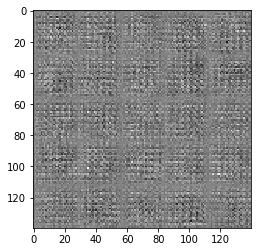

Epoch 1/2... Discriminator Loss: 0.4684... Generator Loss: 2.6413
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 2.2078
Epoch 1/2... Discriminator Loss: 5.1316... Generator Loss: 0.0689
Epoch 1/2... Discriminator Loss: 0.6840... Generator Loss: 1.5653
Epoch 1/2... Discriminator Loss: 0.4613... Generator Loss: 2.8249
Epoch 1/2... Discriminator Loss: 0.5909... Generator Loss: 1.3886
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 2.3938
Epoch 1/2... Discriminator Loss: 2.2904... Generator Loss: 0.6345
Epoch 1/2... Discriminator Loss: 1.9699... Generator Loss: 0.6008
Epoch 1/2... Discriminator Loss: 1.1815... Generator Loss: 0.5758


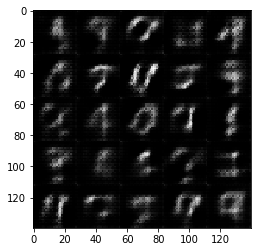

Epoch 1/2... Discriminator Loss: 1.2203... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.1778... Generator Loss: 0.9798
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 1.0779
Epoch 1/2... Discriminator Loss: 1.2634... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 0.9720... Generator Loss: 1.1526
Epoch 1/2... Discriminator Loss: 1.7867... Generator Loss: 2.7539
Epoch 1/2... Discriminator Loss: 1.3110... Generator Loss: 0.4835
Epoch 1/2... Discriminator Loss: 1.2808... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.2572... Generator Loss: 0.9599
Epoch 1/2... Discriminator Loss: 1.0918... Generator Loss: 0.9545


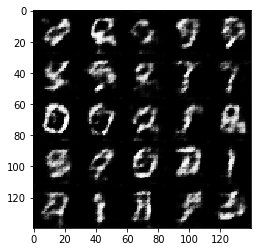

Epoch 1/2... Discriminator Loss: 1.1470... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.1312... Generator Loss: 0.7099
Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.9125
Epoch 1/2... Discriminator Loss: 1.2447... Generator Loss: 1.9195
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.7339
Epoch 1/2... Discriminator Loss: 1.0609... Generator Loss: 0.7651
Epoch 1/2... Discriminator Loss: 1.7500... Generator Loss: 0.2853
Epoch 1/2... Discriminator Loss: 2.1613... Generator Loss: 0.1627
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 1.3731
Epoch 1/2... Discriminator Loss: 1.4907... Generator Loss: 1.0730


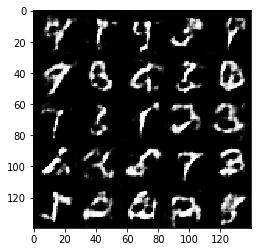

Epoch 1/2... Discriminator Loss: 1.8537... Generator Loss: 0.2560
Epoch 1/2... Discriminator Loss: 1.4539... Generator Loss: 0.3991
Epoch 1/2... Discriminator Loss: 1.8829... Generator Loss: 0.2541
Epoch 1/2... Discriminator Loss: 1.5257... Generator Loss: 0.4555
Epoch 1/2... Discriminator Loss: 1.1889... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.6812
Epoch 1/2... Discriminator Loss: 1.4106... Generator Loss: 2.1029
Epoch 1/2... Discriminator Loss: 1.2662... Generator Loss: 0.5276
Epoch 1/2... Discriminator Loss: 1.6157... Generator Loss: 0.2972
Epoch 1/2... Discriminator Loss: 1.9903... Generator Loss: 2.4219


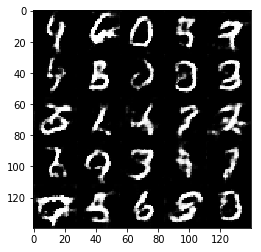

Epoch 1/2... Discriminator Loss: 1.0568... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.5648
Epoch 1/2... Discriminator Loss: 1.2565... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.3309... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.7246
Epoch 1/2... Discriminator Loss: 1.0531... Generator Loss: 0.8735
Epoch 1/2... Discriminator Loss: 1.1322... Generator Loss: 1.2456
Epoch 1/2... Discriminator Loss: 1.1042... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.6190
Epoch 1/2... Discriminator Loss: 1.7061... Generator Loss: 2.1700


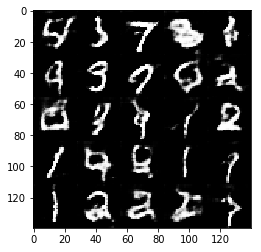

Epoch 1/2... Discriminator Loss: 1.3606... Generator Loss: 0.4593
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.3715
Epoch 1/2... Discriminator Loss: 1.5359... Generator Loss: 0.3388
Epoch 1/2... Discriminator Loss: 1.1420... Generator Loss: 0.7062
Epoch 1/2... Discriminator Loss: 1.1273... Generator Loss: 0.7388
Epoch 1/2... Discriminator Loss: 1.0673... Generator Loss: 1.6249
Epoch 1/2... Discriminator Loss: 1.0775... Generator Loss: 0.8900
Epoch 1/2... Discriminator Loss: 1.0418... Generator Loss: 0.8305
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 1.8462
Epoch 1/2... Discriminator Loss: 0.9953... Generator Loss: 1.0525


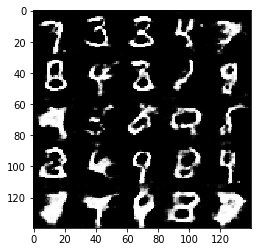

Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 1.4624
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 0.9517
Epoch 1/2... Discriminator Loss: 1.5455... Generator Loss: 0.3572
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.6690
Epoch 1/2... Discriminator Loss: 1.0613... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.6733
Epoch 1/2... Discriminator Loss: 1.4781... Generator Loss: 2.0105
Epoch 1/2... Discriminator Loss: 1.3927... Generator Loss: 1.3404
Epoch 1/2... Discriminator Loss: 1.3152... Generator Loss: 0.5442
Epoch 1/2... Discriminator Loss: 1.0840... Generator Loss: 1.8778


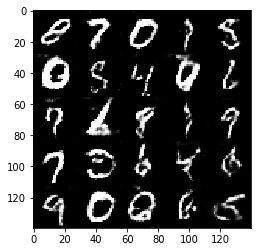

Epoch 1/2... Discriminator Loss: 1.0627... Generator Loss: 0.6461
Epoch 1/2... Discriminator Loss: 1.6857... Generator Loss: 0.3124
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.1540
Epoch 1/2... Discriminator Loss: 1.6699... Generator Loss: 0.3390
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 0.9118
Epoch 1/2... Discriminator Loss: 1.6145... Generator Loss: 0.2949
Epoch 1/2... Discriminator Loss: 1.5263... Generator Loss: 0.3954
Epoch 1/2... Discriminator Loss: 1.0854... Generator Loss: 0.7154
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 0.7106
Epoch 1/2... Discriminator Loss: 0.9363... Generator Loss: 1.0517


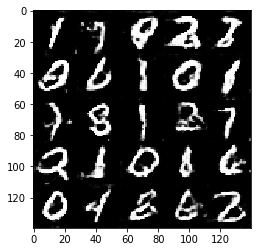

Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.3434
Epoch 1/2... Discriminator Loss: 1.1952... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 1.1888... Generator Loss: 1.1723
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 1.1322
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 0.7043
Epoch 1/2... Discriminator Loss: 1.4139... Generator Loss: 0.3892
Epoch 1/2... Discriminator Loss: 1.8593... Generator Loss: 2.6633
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 1.1361
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.6202


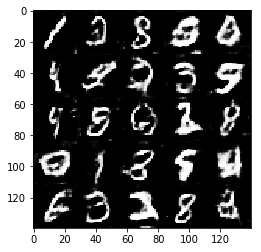

Epoch 1/2... Discriminator Loss: 0.8052... Generator Loss: 1.2241
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.8006
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.5026
Epoch 2/2... Discriminator Loss: 1.0630... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 1.3152... Generator Loss: 0.4635
Epoch 2/2... Discriminator Loss: 1.1075... Generator Loss: 0.6516
Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.4063
Epoch 2/2... Discriminator Loss: 1.2243... Generator Loss: 1.4553
Epoch 2/2... Discriminator Loss: 0.9508... Generator Loss: 1.0461
Epoch 2/2... Discriminator Loss: 1.3359... Generator Loss: 0.5006


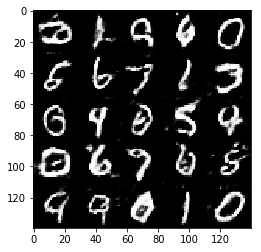

Epoch 2/2... Discriminator Loss: 1.7761... Generator Loss: 0.2655
Epoch 2/2... Discriminator Loss: 0.8059... Generator Loss: 1.1962
Epoch 2/2... Discriminator Loss: 1.5355... Generator Loss: 0.4336
Epoch 2/2... Discriminator Loss: 1.2846... Generator Loss: 1.3984
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.7483
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 0.6972
Epoch 2/2... Discriminator Loss: 1.1471... Generator Loss: 1.1011
Epoch 2/2... Discriminator Loss: 1.5230... Generator Loss: 0.3319
Epoch 2/2... Discriminator Loss: 1.8910... Generator Loss: 0.2370
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.6100


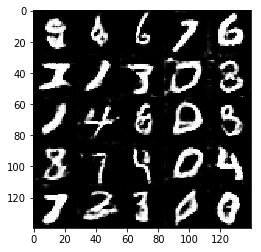

Epoch 2/2... Discriminator Loss: 1.6886... Generator Loss: 0.3046
Epoch 2/2... Discriminator Loss: 1.3111... Generator Loss: 2.6402
Epoch 2/2... Discriminator Loss: 1.0531... Generator Loss: 0.6697
Epoch 2/2... Discriminator Loss: 1.0083... Generator Loss: 1.4208
Epoch 2/2... Discriminator Loss: 1.0293... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 1.2348... Generator Loss: 0.9616
Epoch 2/2... Discriminator Loss: 1.1972... Generator Loss: 0.5142
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.2771
Epoch 2/2... Discriminator Loss: 0.6635... Generator Loss: 1.8442
Epoch 2/2... Discriminator Loss: 1.4632... Generator Loss: 0.4416


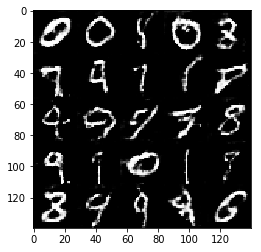

Epoch 2/2... Discriminator Loss: 0.8034... Generator Loss: 1.5993
Epoch 2/2... Discriminator Loss: 1.1300... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 1.0241... Generator Loss: 0.6668
Epoch 2/2... Discriminator Loss: 1.7442... Generator Loss: 0.3090
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.5717
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.6742
Epoch 2/2... Discriminator Loss: 0.9064... Generator Loss: 1.2141
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.8077
Epoch 2/2... Discriminator Loss: 1.7306... Generator Loss: 0.3003
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.5567


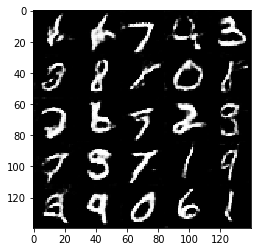

Epoch 2/2... Discriminator Loss: 1.0618... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.2110... Generator Loss: 0.5605
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 0.7698
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.4209
Epoch 2/2... Discriminator Loss: 1.6596... Generator Loss: 0.3153
Epoch 2/2... Discriminator Loss: 1.2782... Generator Loss: 0.4897
Epoch 2/2... Discriminator Loss: 0.9421... Generator Loss: 0.7652
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 0.9713
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 0.6417
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 2.2193


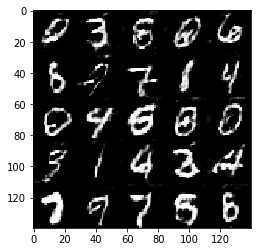

Epoch 2/2... Discriminator Loss: 1.0276... Generator Loss: 0.6883
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 0.7730
Epoch 2/2... Discriminator Loss: 0.8846... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 0.7103
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.1535
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.6812
Epoch 2/2... Discriminator Loss: 1.8289... Generator Loss: 0.2696
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 1.8557... Generator Loss: 0.2864
Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 0.3672


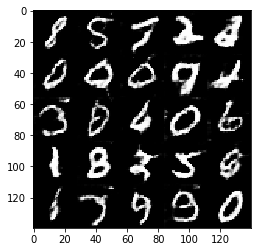

Epoch 2/2... Discriminator Loss: 2.1017... Generator Loss: 0.2333
Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.6485
Epoch 2/2... Discriminator Loss: 2.2847... Generator Loss: 0.1826
Epoch 2/2... Discriminator Loss: 1.0039... Generator Loss: 1.6321
Epoch 2/2... Discriminator Loss: 0.8459... Generator Loss: 0.9395
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 0.6502
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 0.9287... Generator Loss: 0.7377
Epoch 2/2... Discriminator Loss: 0.6272... Generator Loss: 1.9589
Epoch 2/2... Discriminator Loss: 1.4875... Generator Loss: 0.4926


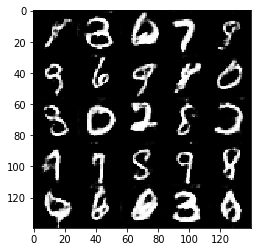

Epoch 2/2... Discriminator Loss: 0.7415... Generator Loss: 1.1569
Epoch 2/2... Discriminator Loss: 1.1569... Generator Loss: 0.5849
Epoch 2/2... Discriminator Loss: 1.3469... Generator Loss: 0.5308
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.5183
Epoch 2/2... Discriminator Loss: 0.8858... Generator Loss: 0.9558
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 1.5702
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 0.9501
Epoch 2/2... Discriminator Loss: 0.7595... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 1.3951... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 0.7146


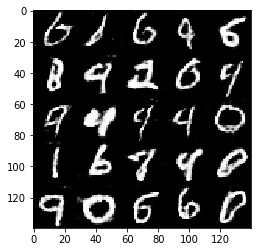

Epoch 2/2... Discriminator Loss: 1.1367... Generator Loss: 0.6779
Epoch 2/2... Discriminator Loss: 1.5098... Generator Loss: 0.3537
Epoch 2/2... Discriminator Loss: 0.9570... Generator Loss: 1.9240
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.7075
Epoch 2/2... Discriminator Loss: 0.7522... Generator Loss: 1.0522
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 1.3588
Epoch 2/2... Discriminator Loss: 1.2905... Generator Loss: 2.6036
Epoch 2/2... Discriminator Loss: 1.0893... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 0.8706... Generator Loss: 1.2416
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.8049


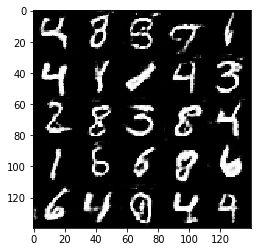

Epoch 2/2... Discriminator Loss: 0.5921... Generator Loss: 1.3608
Epoch 2/2... Discriminator Loss: 0.6949... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: 0.7188... Generator Loss: 3.4256
Epoch 2/2... Discriminator Loss: 2.2855... Generator Loss: 0.1759
Epoch 2/2... Discriminator Loss: 1.1769... Generator Loss: 0.6282
Epoch 2/2... Discriminator Loss: 0.7579... Generator Loss: 3.1982
Epoch 2/2... Discriminator Loss: 1.8921... Generator Loss: 0.2684


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

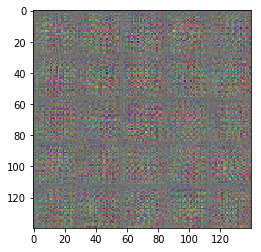

Epoch 1/2... Discriminator Loss: 0.9801... Generator Loss: 11.4817
Epoch 1/2... Discriminator Loss: 1.6227... Generator Loss: 11.2368
Epoch 1/2... Discriminator Loss: 1.0128... Generator Loss: 1.3012
Epoch 1/2... Discriminator Loss: 6.7746... Generator Loss: 0.0078
Epoch 1/2... Discriminator Loss: 1.5593... Generator Loss: 1.3639
Epoch 1/2... Discriminator Loss: 1.2904... Generator Loss: 0.4979
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 0.6730
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.4583
Epoch 1/2... Discriminator Loss: 0.9139... Generator Loss: 2.1351
Epoch 1/2... Discriminator Loss: 0.8743... Generator Loss: 2.6806


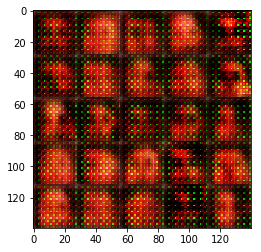

Epoch 1/2... Discriminator Loss: 0.6563... Generator Loss: 1.2502
Epoch 1/2... Discriminator Loss: 0.6109... Generator Loss: 2.1155
Epoch 1/2... Discriminator Loss: 2.1085... Generator Loss: 1.5659
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.3885
Epoch 1/2... Discriminator Loss: 0.7746... Generator Loss: 2.1069
Epoch 1/2... Discriminator Loss: 1.7053... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.6396
Epoch 1/2... Discriminator Loss: 1.2356... Generator Loss: 0.5460
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.7225
Epoch 1/2... Discriminator Loss: 1.2578... Generator Loss: 3.6108


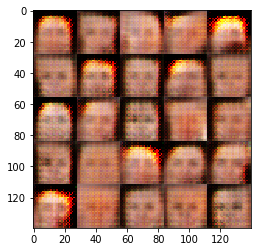

Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 0.5552
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 1.2789
Epoch 1/2... Discriminator Loss: 2.9660... Generator Loss: 2.1635
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.0728
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 1.0188
Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 0.6366
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 0.7183
Epoch 1/2... Discriminator Loss: 1.6632... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 0.6399... Generator Loss: 1.5041
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.6761


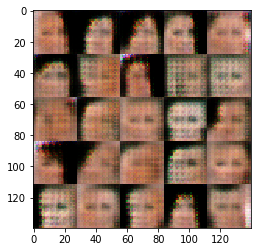

Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.7532
Epoch 1/2... Discriminator Loss: 0.9353... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 0.8506... Generator Loss: 0.9485
Epoch 1/2... Discriminator Loss: 1.2435... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.3852... Generator Loss: 1.7005
Epoch 1/2... Discriminator Loss: 0.7701... Generator Loss: 1.4933
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 0.6578
Epoch 1/2... Discriminator Loss: 1.1294... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 0.8013... Generator Loss: 1.1405


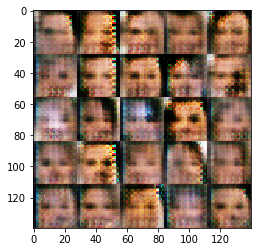

Epoch 1/2... Discriminator Loss: 1.3213... Generator Loss: 0.6065
Epoch 1/2... Discriminator Loss: 0.9844... Generator Loss: 0.9946
Epoch 1/2... Discriminator Loss: 1.5425... Generator Loss: 0.3411
Epoch 1/2... Discriminator Loss: 1.6515... Generator Loss: 0.3650
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.8602
Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 0.4590
Epoch 1/2... Discriminator Loss: 0.8831... Generator Loss: 1.1728
Epoch 1/2... Discriminator Loss: 1.8416... Generator Loss: 0.3240
Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 0.6337
Epoch 1/2... Discriminator Loss: 1.3016... Generator Loss: 0.6110


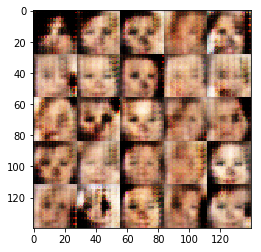

Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.0374
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 0.8627
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 0.6379
Epoch 1/2... Discriminator Loss: 1.1175... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 1.2060
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.4632
Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 0.8166
Epoch 1/2... Discriminator Loss: 0.7794... Generator Loss: 1.1003
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 2.1590... Generator Loss: 0.3471


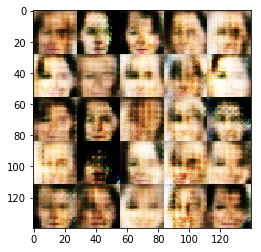

Epoch 1/2... Discriminator Loss: 1.7891... Generator Loss: 0.3377
Epoch 1/2... Discriminator Loss: 0.7399... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 1.6022... Generator Loss: 0.4060
Epoch 1/2... Discriminator Loss: 1.0630... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 1.1590
Epoch 1/2... Discriminator Loss: 1.3021... Generator Loss: 0.7804
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 1.5604... Generator Loss: 1.2076
Epoch 1/2... Discriminator Loss: 1.2126... Generator Loss: 0.8815
Epoch 1/2... Discriminator Loss: 0.8128... Generator Loss: 0.9485


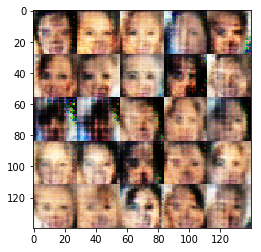

Epoch 1/2... Discriminator Loss: 1.3917... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 1.1374
Epoch 1/2... Discriminator Loss: 1.2819... Generator Loss: 1.1543
Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 1.3676
Epoch 1/2... Discriminator Loss: 1.0975... Generator Loss: 1.5625
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.9160
Epoch 1/2... Discriminator Loss: 1.8722... Generator Loss: 0.2800
Epoch 1/2... Discriminator Loss: 0.8991... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 0.8945


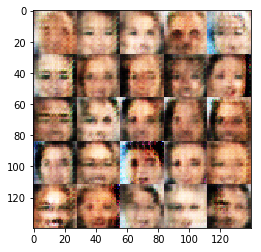

Epoch 1/2... Discriminator Loss: 1.4791... Generator Loss: 0.4533
Epoch 1/2... Discriminator Loss: 1.4863... Generator Loss: 1.7508
Epoch 1/2... Discriminator Loss: 1.6186... Generator Loss: 1.7060
Epoch 1/2... Discriminator Loss: 1.4969... Generator Loss: 1.8210
Epoch 1/2... Discriminator Loss: 1.1027... Generator Loss: 1.3071
Epoch 1/2... Discriminator Loss: 0.8910... Generator Loss: 1.0950
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 0.7169... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 2.3722... Generator Loss: 0.1607
Epoch 1/2... Discriminator Loss: 1.2173... Generator Loss: 0.9350


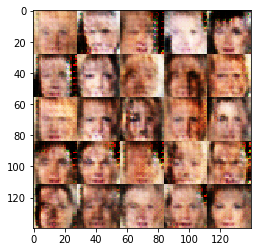

Epoch 1/2... Discriminator Loss: 1.4199... Generator Loss: 1.4739
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.4995
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 1.1354... Generator Loss: 0.7939
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 1.6933
Epoch 1/2... Discriminator Loss: 2.0277... Generator Loss: 2.1289
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 1.1252
Epoch 1/2... Discriminator Loss: 1.0310... Generator Loss: 1.2071
Epoch 1/2... Discriminator Loss: 1.6889... Generator Loss: 0.3883


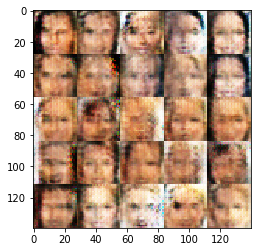

Epoch 1/2... Discriminator Loss: 1.1342... Generator Loss: 0.7169
Epoch 1/2... Discriminator Loss: 1.5948... Generator Loss: 1.7450
Epoch 1/2... Discriminator Loss: 1.1413... Generator Loss: 0.9210
Epoch 1/2... Discriminator Loss: 0.7574... Generator Loss: 0.8894
Epoch 1/2... Discriminator Loss: 1.5579... Generator Loss: 0.3139
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 1.1638
Epoch 1/2... Discriminator Loss: 1.2249... Generator Loss: 0.8061
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 0.9134
Epoch 1/2... Discriminator Loss: 1.1841... Generator Loss: 0.9753
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 0.9702


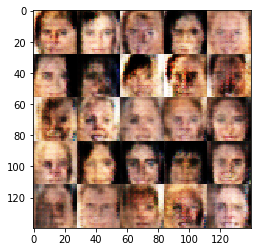

Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.7635
Epoch 1/2... Discriminator Loss: 1.6732... Generator Loss: 0.2516
Epoch 1/2... Discriminator Loss: 1.5552... Generator Loss: 0.3608
Epoch 1/2... Discriminator Loss: 1.0134... Generator Loss: 0.7416
Epoch 1/2... Discriminator Loss: 1.1794... Generator Loss: 0.5570
Epoch 1/2... Discriminator Loss: 0.7874... Generator Loss: 1.0580
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.8045
Epoch 1/2... Discriminator Loss: 1.5132... Generator Loss: 0.3659
Epoch 1/2... Discriminator Loss: 1.7803... Generator Loss: 0.3052
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 0.8697


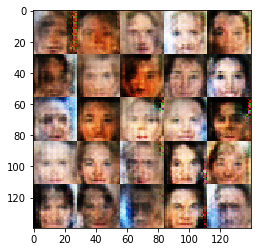

Epoch 1/2... Discriminator Loss: 1.0786... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.7709
Epoch 1/2... Discriminator Loss: 2.9450... Generator Loss: 2.8271
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 1.1135
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 0.5889
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 0.7430
Epoch 1/2... Discriminator Loss: 1.4537... Generator Loss: 0.4677
Epoch 1/2... Discriminator Loss: 1.6009... Generator Loss: 0.3468
Epoch 1/2... Discriminator Loss: 1.3184... Generator Loss: 0.6087
Epoch 1/2... Discriminator Loss: 3.2804... Generator Loss: 3.5615


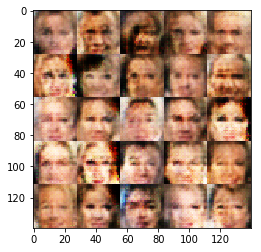

Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 1.1542
Epoch 1/2... Discriminator Loss: 1.0610... Generator Loss: 0.7105
Epoch 1/2... Discriminator Loss: 1.1844... Generator Loss: 1.9404
Epoch 1/2... Discriminator Loss: 1.0744... Generator Loss: 0.9755
Epoch 2/2... Discriminator Loss: 1.2284... Generator Loss: 1.4902
Epoch 2/2... Discriminator Loss: 0.9928... Generator Loss: 2.0427
Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 1.0196... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 1.0333
Epoch 2/2... Discriminator Loss: 1.5563... Generator Loss: 0.3949


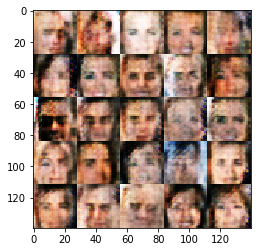

Epoch 2/2... Discriminator Loss: 1.2736... Generator Loss: 0.5554
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 1.7741
Epoch 2/2... Discriminator Loss: 1.5809... Generator Loss: 0.5661
Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 0.5798
Epoch 2/2... Discriminator Loss: 1.4872... Generator Loss: 0.3853
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.7474
Epoch 2/2... Discriminator Loss: 1.3078... Generator Loss: 1.1100
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 1.2385
Epoch 2/2... Discriminator Loss: 1.1586... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 1.2376... Generator Loss: 0.9838


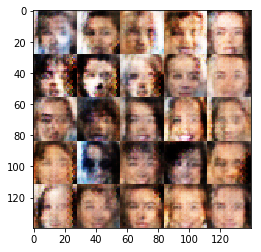

Epoch 2/2... Discriminator Loss: 1.2805... Generator Loss: 0.4844
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.7406
Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 1.2620
Epoch 2/2... Discriminator Loss: 1.3253... Generator Loss: 0.5112
Epoch 2/2... Discriminator Loss: 0.7092... Generator Loss: 1.2316
Epoch 2/2... Discriminator Loss: 3.6790... Generator Loss: 4.5948
Epoch 2/2... Discriminator Loss: 1.0370... Generator Loss: 1.4275
Epoch 2/2... Discriminator Loss: 1.2210... Generator Loss: 0.8082
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 1.2481... Generator Loss: 0.5461


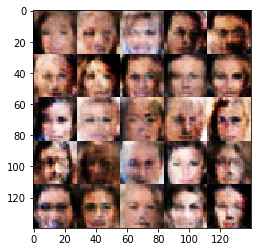

Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 1.2285
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.9224
Epoch 2/2... Discriminator Loss: 0.9123... Generator Loss: 1.3639
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.0511
Epoch 2/2... Discriminator Loss: 0.9450... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 1.2730... Generator Loss: 1.2996
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 1.0332
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.6238
Epoch 2/2... Discriminator Loss: 1.0561... Generator Loss: 0.8184
Epoch 2/2... Discriminator Loss: 1.1693... Generator Loss: 1.1316


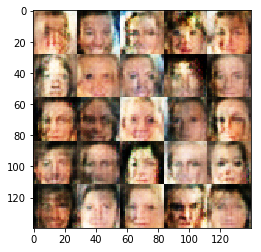

Epoch 2/2... Discriminator Loss: 1.4679... Generator Loss: 0.3996
Epoch 2/2... Discriminator Loss: 1.2626... Generator Loss: 1.6756
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 1.5280... Generator Loss: 0.3363
Epoch 2/2... Discriminator Loss: 1.4276... Generator Loss: 3.1968
Epoch 2/2... Discriminator Loss: 1.0728... Generator Loss: 0.5436
Epoch 2/2... Discriminator Loss: 1.1152... Generator Loss: 0.7830
Epoch 2/2... Discriminator Loss: 0.6376... Generator Loss: 1.8457
Epoch 2/2... Discriminator Loss: 0.7698... Generator Loss: 1.4398
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 1.2880


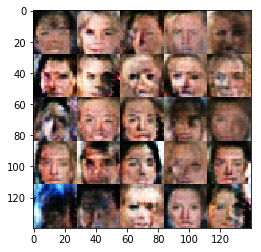

Epoch 2/2... Discriminator Loss: 1.0825... Generator Loss: 1.1159
Epoch 2/2... Discriminator Loss: 0.9889... Generator Loss: 0.7920
Epoch 2/2... Discriminator Loss: 1.1591... Generator Loss: 0.6827
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 0.4827
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 1.0289
Epoch 2/2... Discriminator Loss: 1.2121... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 1.6677... Generator Loss: 0.3051
Epoch 2/2... Discriminator Loss: 1.4041... Generator Loss: 0.5153
Epoch 2/2... Discriminator Loss: 0.9468... Generator Loss: 1.5789
Epoch 2/2... Discriminator Loss: 1.2146... Generator Loss: 0.8515


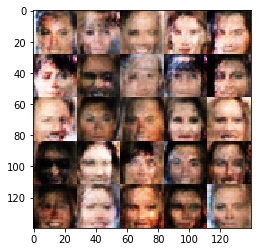

Epoch 2/2... Discriminator Loss: 1.1419... Generator Loss: 1.0703
Epoch 2/2... Discriminator Loss: 1.4238... Generator Loss: 0.3884
Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.5004
Epoch 2/2... Discriminator Loss: 1.6796... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 0.8822... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 1.0734... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 1.3614... Generator Loss: 0.4103
Epoch 2/2... Discriminator Loss: 1.0575... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 1.4533... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 0.9630


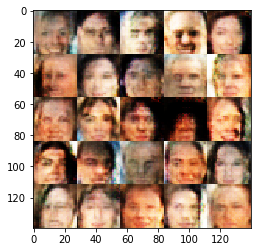

Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.5947
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 1.2086
Epoch 2/2... Discriminator Loss: 1.2753... Generator Loss: 0.6409
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 1.2029
Epoch 2/2... Discriminator Loss: 1.1112... Generator Loss: 0.7165
Epoch 2/2... Discriminator Loss: 1.4790... Generator Loss: 1.6330
Epoch 2/2... Discriminator Loss: 1.0664... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 1.4694... Generator Loss: 1.2392
Epoch 2/2... Discriminator Loss: 1.2637... Generator Loss: 0.6189
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.8856


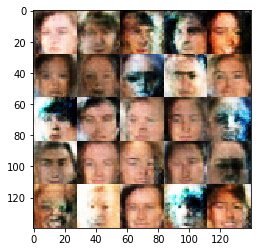

Epoch 2/2... Discriminator Loss: 0.7661... Generator Loss: 1.1156
Epoch 2/2... Discriminator Loss: 1.2591... Generator Loss: 0.7415
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.6820
Epoch 2/2... Discriminator Loss: 1.6082... Generator Loss: 0.3739
Epoch 2/2... Discriminator Loss: 1.2710... Generator Loss: 0.7214
Epoch 2/2... Discriminator Loss: 0.6569... Generator Loss: 1.5157
Epoch 2/2... Discriminator Loss: 1.3186... Generator Loss: 0.8532
Epoch 2/2... Discriminator Loss: 1.3763... Generator Loss: 0.4800
Epoch 2/2... Discriminator Loss: 1.2974... Generator Loss: 0.8211
Epoch 2/2... Discriminator Loss: 1.1870... Generator Loss: 0.9488


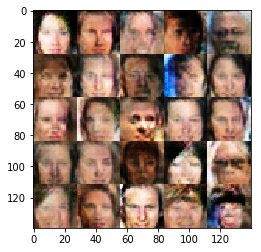

Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.9391
Epoch 2/2... Discriminator Loss: 1.4530... Generator Loss: 0.6192
Epoch 2/2... Discriminator Loss: 1.0787... Generator Loss: 0.6458
Epoch 2/2... Discriminator Loss: 1.2224... Generator Loss: 0.6082
Epoch 2/2... Discriminator Loss: 1.0935... Generator Loss: 1.0369
Epoch 2/2... Discriminator Loss: 0.9738... Generator Loss: 0.9858
Epoch 2/2... Discriminator Loss: 1.1976... Generator Loss: 0.7291
Epoch 2/2... Discriminator Loss: 1.7191... Generator Loss: 1.7082
Epoch 2/2... Discriminator Loss: 0.5219... Generator Loss: 1.3917
Epoch 2/2... Discriminator Loss: 1.4223... Generator Loss: 0.6870


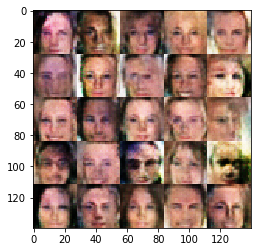

Epoch 2/2... Discriminator Loss: 1.1316... Generator Loss: 0.7941
Epoch 2/2... Discriminator Loss: 1.3419... Generator Loss: 0.5221
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 0.9526
Epoch 2/2... Discriminator Loss: 1.4164... Generator Loss: 0.5348
Epoch 2/2... Discriminator Loss: 1.0496... Generator Loss: 0.8174
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 1.0119
Epoch 2/2... Discriminator Loss: 1.3110... Generator Loss: 0.8687
Epoch 2/2... Discriminator Loss: 1.1301... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 0.9269... Generator Loss: 0.8029
Epoch 2/2... Discriminator Loss: 0.2317... Generator Loss: 1.9285


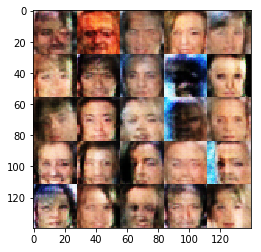

Epoch 2/2... Discriminator Loss: 1.4575... Generator Loss: 1.1882
Epoch 2/2... Discriminator Loss: 1.5097... Generator Loss: 1.0103
Epoch 2/2... Discriminator Loss: 1.2834... Generator Loss: 0.5905
Epoch 2/2... Discriminator Loss: 1.1061... Generator Loss: 0.9239
Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 0.6164
Epoch 2/2... Discriminator Loss: 1.5295... Generator Loss: 0.3971
Epoch 2/2... Discriminator Loss: 1.2568... Generator Loss: 0.5316
Epoch 2/2... Discriminator Loss: 1.0378... Generator Loss: 0.8544
Epoch 2/2... Discriminator Loss: 1.3096... Generator Loss: 0.4846
Epoch 2/2... Discriminator Loss: 1.3322... Generator Loss: 0.7332


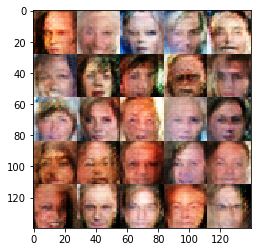

Epoch 2/2... Discriminator Loss: 1.0971... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 1.1108... Generator Loss: 1.0338
Epoch 2/2... Discriminator Loss: 1.1882... Generator Loss: 0.8381
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.5455
Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.6817
Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 1.2092
Epoch 2/2... Discriminator Loss: 1.2599... Generator Loss: 1.1951
Epoch 2/2... Discriminator Loss: 1.0708... Generator Loss: 1.2785
Epoch 2/2... Discriminator Loss: 1.4534... Generator Loss: 0.7388
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.9038


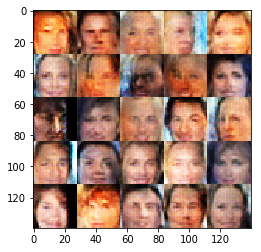

Epoch 2/2... Discriminator Loss: 1.8918... Generator Loss: 1.9355
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.8086
Epoch 2/2... Discriminator Loss: 1.3327... Generator Loss: 0.8811
Epoch 2/2... Discriminator Loss: 1.1418... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.6066
Epoch 2/2... Discriminator Loss: 1.1676... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 1.1478... Generator Loss: 0.8651


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。